# Probmods: Chapter 3

In this notebook I will translate a selection of the example code snippets from Chapter 3 of the probmods book into Pyro. The original book is written using webPPL, and is available at https://probmods.org/.

In [1]:
import torch
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

## Rejection sampling

```javascript
//original webPPL code
var takeSample = function () {
    var A = flip()
    var B = flip()
    var C = flip()
    var D = A + B + C
    return D >= 2 ? A : takeSample()
}
viz(repeat(100, takeSample))
```

<AxesSubplot:ylabel='Count'>

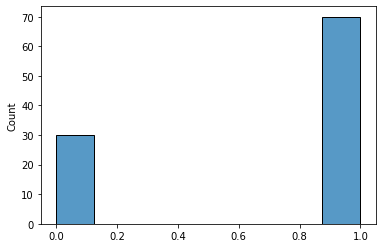

In [2]:
def takeSample(t=None):    
    if t is None:
        t = 0
    A = pyro.sample("A_{}".format(t), pyro.distributions.Bernoulli(.5))
    B = pyro.sample("B_{}".format(t), pyro.distributions.Bernoulli(.5))
    C = pyro.sample("B_{}".format(t), pyro.distributions.Bernoulli(.5))
    D = A + B + C
    if D >= 2:
        return A
    else:
        return takeSample(t+1)
        
sns.histplot(np.array([takeSample() for _ in range(100)]))

Don't want to implement rejection manually, but instead condition our model.

```javascript
//original webPPL code
var model = function () {
    var A = flip()
    var B = flip()
    var C = flip()
    var D = A + B + C
    condition(D >= 2)
    return A
}
var dist = Infer({method: 'rejection', samples: 100}, model)
viz(dist)
```


Conditioning on boolean constraints is a bit different in `pyro`. This [forum post](https://forum.pyro.ai/t/achieving-observe-behavior/1687/2) is helpful for getting behavior like webPPL's `observe` function. There is a tiny fudge factor involved here but it should be fine.

<AxesSubplot:ylabel='Count'>

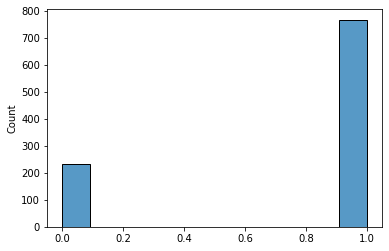

In [3]:
def model():
    A = pyro.sample("A", dist.Bernoulli(.5))
    B = pyro.sample("B", dist.Bernoulli(.5))
    C = pyro.sample("C", dist.Bernoulli(.5))
    D = A + B + C
    
    pyro.sample("obs", dist.Bernoulli(.9999), obs = (D >= 2.).float())

    return A

posterior = Importance(model, num_samples=1000)
marginal = EmpiricalMarginal(posterior.run())

sns.histplot(np.array([marginal.sample() for _ in range(1000)]))

```javascript
//original webPPL code
var observedData = true;
var prior = function () { flip() }
var likelihood = function (h) { h ? flip(0.9) : flip(0.1) }

var posterior = Infer(
  function () {
    var hypothesis = prior()
    var data = likelihood(hypothesis)
    condition(data == observedData)
    return {hypothesis: hypothesis}
})

viz(posterior)
```

<AxesSubplot:ylabel='Count'>

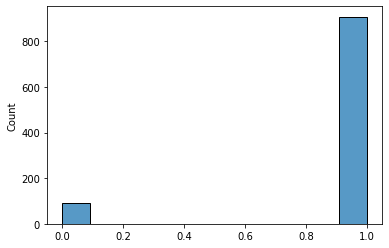

In [4]:
observedData = torch.tensor(1.) # gotta be careful to respect torch! warnings aren't much help

def prior():
    return pyro.sample("hypothesis", dist.Bernoulli(.5))

def likelihood(h):
    if h:
        p = .9
    else:
        p = .1
    return dist.Bernoulli(p)

def posterior_model():
    hypothesis = prior()
    data = likelihood(hypothesis)
    pyro.sample("likeli", data, obs=observedData)
    return hypothesis


posterior = Importance(posterior_model, num_samples=1000)
marginal = EmpiricalMarginal(posterior.run())

sns.histplot(np.array([marginal.sample() for _ in range(1000)]))


Other methods for inference (and conditioning continuous variables). In Pyro `condition()` appears to work like webPPL's `observe()`.

```javascript
var model = function(){
  var trueX = sample(Gaussian({mu: 0, sigma: 1}))
  observe(Gaussian({mu: trueX, sigma: 0.1}), 0.2)
  return trueX
}
viz(Infer({method: 'rejection', samples:1000, maxScore: 2}, model))
```

(should add the bit about `factor()`)

## Example: Reasoning about Tug of War

```javascript
//original webPPL code
var strength = mem(function (person) {return Math.abs(gaussian(1, 1), 0.01)})
var lazy = function(person) {return flip(1/3) }
var pulling = function(person) {
  return lazy(person) ? strength(person) / 2 : strength(person) }
var totalPulling = function (team) {return sum(map(pulling, team))}
var winner = function (team1, team2) {
  totalPulling(team1) > totalPulling(team2) ? team1 : team2 }

print([
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
])
```

In [5]:

@functools.lru_cache(maxsize=128)
def strength(person):
    return torch.abs(pyro.sample("s_{}".format(person), dist.Normal(1,1)))
    
def lazy(person):
    return pyro.sample("l_{}".format(person), dist.Bernoulli(1/3))

def pulling(person):
    if lazy(person)==1.:
        return strength(person)/2
    else:
        return strength(person)

def totalPulling(team):
    return torch.sum(torch.tensor([pulling(i) for i in team]))

def winner(team1, team2):
    if totalPulling(team1) > totalPulling(team2):
        return team1
    else:
        return team2
    
print([
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
])

[['alice', 'bob'], ['alice', 'bob'], ['alice', 'sue'], ['alice', 'sue'], ['bob', 'sue'], ['bob', 'sue']]


```javascript
//original webPPL code
var model = function() {
  var strength = mem(function (person) {return Math.abs(gaussian(1, 1), 0.01)})
  var lazy = function(person) {return flip(1/3) }
  var pulling = function(person) {
    return lazy(person) ? strength(person) / 2 : strength(person) }
  var totalPulling = function (team) {return sum(map(pulling, team))}
  var winner = function (team1, team2) {
    totalPulling(team1) > totalPulling(team2) ? team1 : team2 }
  var beat = function(team1,team2){winner(team1,team2) == team1}

  condition(beat(['bob', 'mary'], ['tom', 'sue']))
  condition(beat(['bob', 'sue'],  ['tom', 'jim']))

  return strength('bob')
}

var dist = Infer({method: 'MCMC', kernel: 'MH', samples: 25000},
                 model)

print('Expected strength: ' + expectation(dist))
viz(dist)
```

To use this model for inference in pyro we need to do a bit of extra book keeping. Specifically, we need to keep track  laziness across rounds so now all the functions but strength() take an additional `rnd` argument.

I was also able to do what looks like reasonable inference on this model using importance sampling rather than MCMC. Because Pyro only implements HMC it cannot be used for models with discrete latent variables (e.g. lazy) without some additional work that I will address in a later example.

<AxesSubplot:ylabel='Density'>

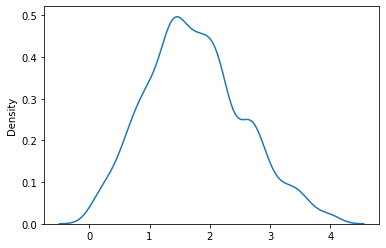

In [6]:
def model():
    @functools.lru_cache(maxsize=128)
    def strength(person):
        return torch.abs(pyro.sample("s_{}".format(person), dist.Normal(1,1)))

    def lazy(person, rnd):
        return pyro.sample("l_{}_{}".format(person, rnd), dist.Bernoulli(1/3))

    def pulling(person, rnd):
        if lazy(person, rnd)==1.:
            return strength(person)/2
        else:
            return strength(person)

    def totalPulling(team, rnd):
        return torch.sum(torch.tensor([pulling(i, rnd) for i in team]))

    def winner(team1, team2, rnd):
        if totalPulling(team1, rnd) > totalPulling(team2, rnd):
            return team1
        else:
            return team2

    def beat(team1, team2, rnd):
        if winner(team1, team2, rnd)==team1:
            return 1.
        else:
            return 0.
    
    beat1 = beat(['bob', 'mary'], ['tom','sue'], 1)
    beat2 = beat(['bob', 'sue'], ['tom','jim'], 2)
    
    pyro.sample("beat1", dist.Bernoulli(.9999), obs=torch.tensor(beat1==1.).float())
    pyro.sample("beat2", dist.Bernoulli(.9999), obs=torch.tensor(beat2==1.).float())
    
    return strength('bob')

## seems to work with importance sampling, not requiring mcmc?
posterior = Importance(model, num_samples=2500)
marginal = EmpiricalMarginal(posterior.run())

sns.kdeplot(np.array([marginal.sample() for _ in range(2000)]))

Reasoning about complex queries, e.g.: "how likely a team of Bob and Mary is to beat a team of Jim and Sue, given that Mary is at least as strong as sue, and Bob beat Jim in a previous direct match up"?

<AxesSubplot:ylabel='Count'>

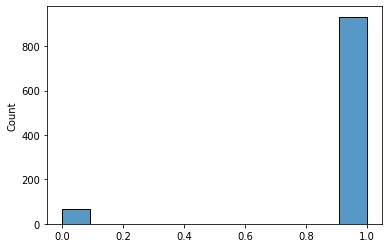

In [7]:
def model2():
    @functools.lru_cache(maxsize=128)
    def strength(person):
        return torch.abs(pyro.sample("s_{}".format(person), dist.Normal(1,1)))

    def lazy(person, rnd):
        return pyro.sample("l_{}_{}".format(person, rnd), dist.Bernoulli(1/3))

    def pulling(person, rnd):
        if lazy(person, rnd)==1.:
            return strength(person)/2
        else:
            return strength(person)

    def totalPulling(team, rnd):
        return torch.sum(torch.tensor([pulling(i, rnd) for i in team]))

    def winner(team1, team2, rnd):
        if totalPulling(team1, rnd) > totalPulling(team2, rnd):
            return team1
        else:
            return team2

    def beat(team1, team2, rnd):
        if winner(team1, team2, rnd)==team1:
            return torch.tensor(1.)
        else:
            return torch.tensor(0.)
    
    str1 = torch.tensor(float(strength('mary')>=strength('sue')))
    beat1 = beat(['bob'], ['jim'],1)
    
    pyro.sample("str1", dist.Bernoulli(.9999), obs=str1)
    pyro.sample("beat1", dist.Bernoulli(.9999), obs=beat1)
    
    return beat(['bob','mary'], ['jim','sue'], 2)

## seems to work with importance sampling, not requiring mcmc?
posterior = Importance(model2, num_samples=2500)
marginal = EmpiricalMarginal(posterior.run())

sns.histplot(np.array([marginal.sample() for _ in range(1000)]))

## Exact inference with discrete Bayesian networks

The next section of probmods is an example of causal inference in medical diagnosis using Causal bayes nets. Because we're dealing with discrete causes, this is a good context for testing exact inference with discrete methods in `pyro`.


```javascript
//original webPPL code
var cancerDist = Infer({method: 'enumerate'},
  function () {
    var breastCancer = flip(0.01)
    var positiveMammogram = breastCancer ? flip(0.8) : flip(0.096)
    condition(positiveMammogram)
    return {breastCancer: breastCancer}
})
viz(cancerDist)
```

In the webppl example they use exact inference by running the `Infer({method: "enumerate"}, ...` method. Pyro is heavily geared around approximate inference, but it can do exact inference as well, as well as enumerating out discrete factors among a larger approximate inference approach. So you can do NUTS and SVI with a few discrete factors included as well. That's a pretty cool advantage over Stan and other implementations.

The pyro docs are not very clear, but [this example](https://forum.pyro.ai/t/obtain-conditional-probabilities-for-discrete-variables/1236/2) from the forums illustrates how to do this. 

Below I try out both exact and approximate inference for this model.

exact p(Cancer = 1|positiveMammogram) = 0.0776
est. p(Cancer = 1|positiveMammogram) = 0.0570


<AxesSubplot:ylabel='Count'>

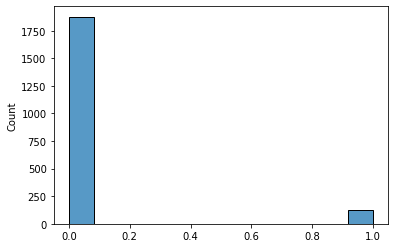

In [9]:
pyro.clear_param_store()

## use config_enumerate decorator
@pyro.infer.config_enumerate
def model():
    breastCancer = pyro.sample("breastCancer", dist.Bernoulli(.01))
    p_pos = torch.where(breastCancer.bool(), .8, .096) # <--- note this is the right way to do this
    pyro.sample("positiveMammogram", dist.Bernoulli(p_pos))
    return breastCancer

def guide(**kwargs):
    pass

# the TraceEnum_ELBO function enumerates out discrete variables
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
p_cpos = pyro.condition(model, data={"positiveMammogram":torch.tensor(1.)})
conditional_marginal = elbo.compute_marginals(p_cpos, guide)

print("exact p(Cancer = 1|positiveMammogram) = {:.4f}".format(
    float(conditional_marginal["breastCancer"].probs))
     )

# can also use approximate inference
posterior = Importance(p_cpos, num_samples=2000)
marginal = EmpiricalMarginal(posterior.run())

print("est. p(Cancer = 1|positiveMammogram) = {:.4f}".format(
    np.mean([marginal.sample() for _ in range(2000)]))
     )
sns.histplot(np.array([marginal.sample() for _ in range(2000)]))




Can represent these same statistical relations as a causal model with another possible cause of positive mammogram results. Note that the `noisy_or()` function is a bit clumsy to write as the number of possible causes increase. In this simple case it's much more direct to just analytically compute the probability, but I also ran into difficulty implementing this in a way that made torch happy.

```javascript
//original webPPL code
var cancerDist = Infer({method: 'enumerate'},
  function () {
    var breastCancer = flip(0.01)
    var benignCyst = flip(0.2)
    var positiveMammogram = (breastCancer && flip(0.8)) || (benignCyst && flip(0.5))
    condition(positiveMammogram)
    return {breastCancer: breastCancer}
});
viz(cancerDist)
```

In [50]:
pyro.clear_param_store()

@pyro.infer.config_enumerate
def model():
    
    def noisy_or(a,b):
        return torch.logical_or(
            torch.logical_and(a, pyro.sample("c1", dist.Bernoulli(.8))),
            torch.logical_and(b, pyro.sample("c2", dist.Bernoulli(.5)))
        ).float()

    breastCancer = pyro.sample("breastCancer", dist.Bernoulli(.01))
    benignCyst = pyro.sample("benignCyst", dist.Bernoulli(.2))
    pyro.sample("positiveMammogram", dist.Bernoulli(.9999), obs = noisy_or(breastCancer, benignCyst))
    
    return breastCancer

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
conditional_marginal = elbo.compute_marginals(model, guide)

print("exact p(Cancer = 1|positiveMammogram) = {:.4f}".format(
    float(conditional_marginal["breastCancer"].probs))
     )

exact p(Cancer = 1|positiveMammogram) = 0.0764
